# Project Final Report
#### Marcus Law, Janesh Tulsan, Winston Tse, Raphael Ysonza

## Introduction

We use a dataset named “players” to perform this project. It is a dataset that has information on the players playing minecraft through PLAICRAFT. "Players" contains 196 rows, 9 columns, 4 columns being strings, 2 columns being decimal numbers, 3 columns being categorical (T or F) variables. To describe these columns in a thorough sense: <br>
`experience` (Categorical) 
- Categorized into: Pro, Veteran, Regular, Amateur, Beginner 
- How much prior experience the person has with Minecraft

`subscribe` (Categorical)
- Either True or False
- If the person subscribed to receive email notifications from Plaicraft

`hashed_email` (Categorical)
- The person’s email, but for privacy it is hashed out

`played_hours` (Quantative) 
- Hours played in Plaicraft
  
`name` (Categorical) 
- Person’s username
  
`gender` (Categorical) 
- Person’s gender
  
`age` (Quantative)
 - Person's age
   
`individual_id` (Categorical)
- Individual IDs given to players, private information so it is all N/A

`organization` (Categorical)
- Private information about a person's organization, also all N/A

In a broad sense, we wanted to know what “kinds” of players are most likely to contribute a large amount of data for PLAICRAFT’s use, so they can optimize their recruiting efforts. Therefore, our technique to find the answer to this question is to find the relationship between playing hours, age and their level of experience with the latter two being our explanatory variables.

## Methods

To perform this project, we’re employing a multivariate k-nn regression. To get started, we loaded the data and wrangled the data. To effectively use the columns in R, we had to clean the names of the variables to accompany the “_” in between spaces. Furthermore, variables such as individual_id, hashed_email and organization_name were not beneficial in contributing data relevant in answering our question, so we decided to discard them. As we decided to use the k-nn regression model, we needed to convert our experience variable into a dummy variable, so we applied the one hot encoding method, which is a method which converts categorical variables to binary format to use in regressions. We mutated all the values for the experience column into columns for themselves. This method ensures that a column for a particular observation has the value “1” if the attribute is true, “0” otherwise. We started our regression by creating a split for the training data with 0.75 as our proportions and played_hours as our strata. This ensures that the data has the same distribution of played_hours in our training and testing dataset. After creating the split, we quickly defined a training and testing data set. Then, we created the model specification and recipe for the model which defined our variables. We also scaled all the predictors as this model uses distance to identify the closest neighbours so the variables should not have more influence over the other while performing this regression. Next we created a cross validation to determine the optimal k value for our k-nn regression without make assumptions about the distribution of the data. We filtered for the k value with the lowest RMSE to make a recipe and workflow using this determined k value to make predictions on the testing data set. Before creating a visualization, we decide to find the RMSPE to understand the data’s prediction errors. We made three visualizations to clearly show the results of our model. Figure 2 shows the predicted number of hours played shown by the line on the original scatter plot with the true values. Figure 3 is a boxplot, used to understand how the predicted hours played is distributed across the experience levels. Figure 4 shows the error (residuals) between the true value and the predicted value. This helps show how well the model captured the underlying patterns in the data as well as help assess whether the k-nn model is systematically overestimating or underestimating in certain areas.

In [2]:
#Loaded libraries necessary for project
library(tidyverse)
library(repr)
library(tidymodels)
library(janitor)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
#Read data set from URL and used janitor library clean_names() so the column names would be consistent and had underscores instead of space to allow for easier use.
url_players <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

player_data <- read_csv(url_players) |>
    clean_names()
player_data

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age,individual_id,organization_name
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17,NA,NA
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,NA,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,91,NA,NA


In [4]:
#Wrangled data: Used one-hot encoding to change experience from a categorical variable to a quantitative variable.
#Also removed outliers: played hours that was greater than 2 standard deviations from the mean and ages that were greater than 90 since those were likely falsified.
players <- player_data |>
    mutate(Pro = ifelse(experience == "Pro", 1, 0),
           Amateur = ifelse(experience == "Amateur", 1, 0),
           Veteran = ifelse(experience == "Veteran", 1, 0),
           Beginner = ifelse(experience == "Beginner", 1, 0),
           Regular = ifelse(experience == "Regular", 1, 0)) |>
    select(-individual_id, -hashed_email, -organization_name) |>
    filter(played_hours < sd(played_hours)*2) |>
    filter(age < 90)

players

experience,subscribe,played_hours,name,gender,age,Pro,Amateur,Veteran,Beginner,Regular
<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pro,TRUE,30.3,Morgan,Male,9,1,0,0,0,0
Veteran,TRUE,3.8,Christian,Male,17,0,0,1,0,0
Veteran,FALSE,0.0,Blake,Male,17,0,0,1,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,0.3,Pascal,Male,22,0,0,1,0,0
Amateur,FALSE,0.0,Dylan,Prefer not to say,17,0,1,0,0,0
Amateur,FALSE,2.3,Harlow,Male,17,0,1,0,0,0


#### Figure 1

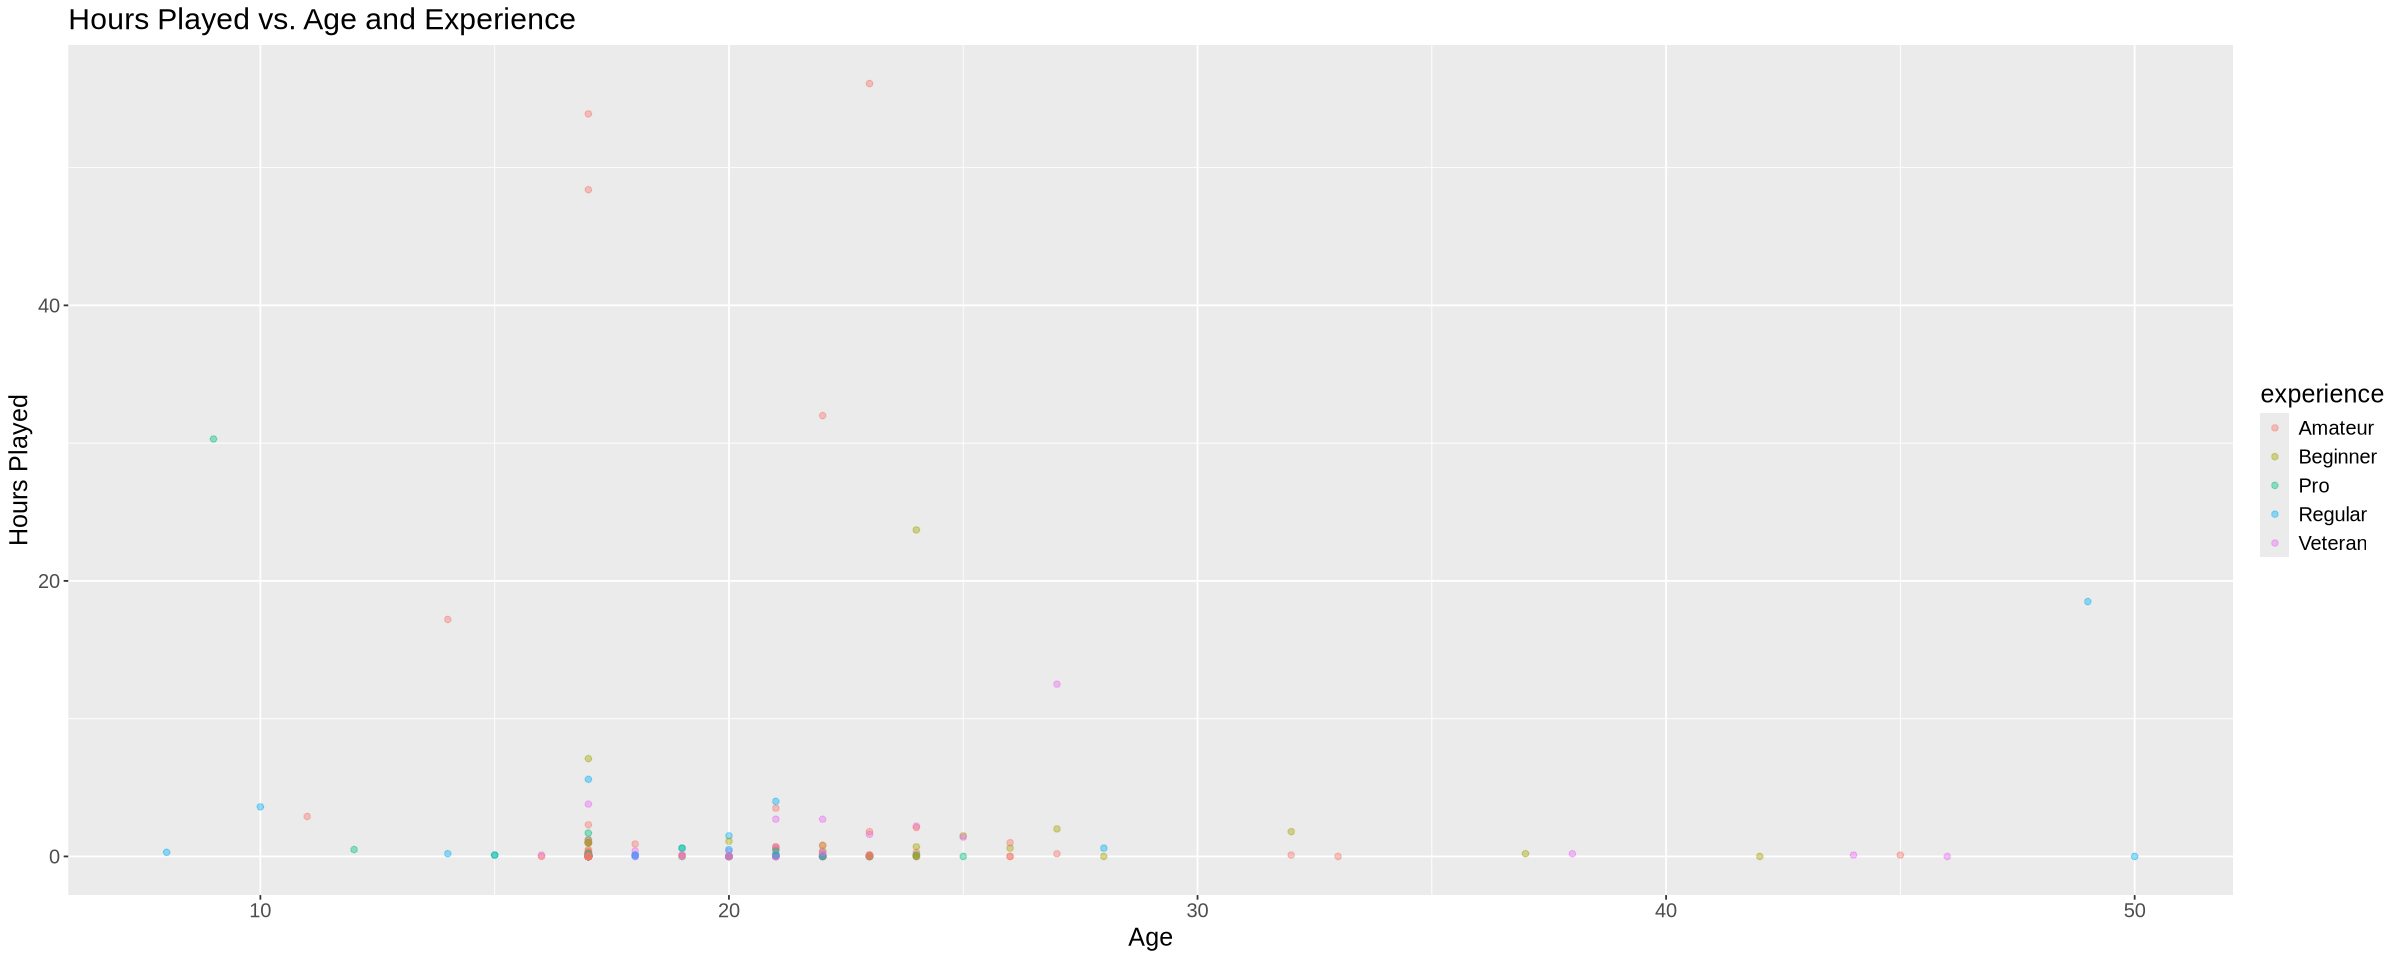

In [5]:
#Visualization of data set with hours played vs. age and colour coded by experience
options(repr.plot.width = 20, repr.plot.height = 8) 

player_EDA <- players |>
ggplot(aes(x = age , y = played_hours, colour = experience)) + 
geom_point(alpha = 0.4) +
labs(x = "Age", 
     y = "Hours Played") +
ggtitle("Hours Played vs. Age and Experience") +
theme(text = element_text(size = 15)) 
player_EDA

In [6]:
#Set seed for reproducibility.
#The player data set was split into 75% training, and 25% testing.
set.seed(1234)
player_split <- initial_split(players, prop = 0.75, strata = played_hours)

player_training <- training(player_split)
player_testing <- testing(player_split)

In [7]:
#Created model for KNN-Regressison with neighbors = tune() so that the ideal k value can be found.
#Created recipe with the desired predictors and scaled all predictors
set.seed(1234)

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

player_recipe <- recipe(played_hours ~ age + Pro + Amateur + Veteran + Beginner + Regular, data = players) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())
player_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [8]:
#Cross validation using vfold_cv with 10 folds to determine the k value for KNN
set.seed(1234)
player_vfold <- vfold_cv(player_training, v = 10, strata = played_hours)

player_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_spec)
player_workflow

gridvals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

player_results <- player_workflow |>
  tune_grid(resamples = player_vfold, grid = gridvals) |>
  collect_metrics()
player_results

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,7.13070680,10,1.76555881,Preprocessor1_Model01
1,rsq,standard,0.01600764,10,0.00445332,Preprocessor1_Model01
2,rmse,standard,9.32548072,10,1.45475880,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,rsq,standard,0.06341947,10,0.01867990,Preprocessor1_Model19
20,rmse,standard,7.29674260,10,1.52899738,Preprocessor1_Model20
20,rsq,standard,0.05523249,10,0.02077538,Preprocessor1_Model20


In [9]:
set.seed(1234)
#Filtered for the k value with the lowest RMSE.
player_min <- player_results |>
   filter(.metric == "rmse") |>
   slice_min(std_err, n = 1)
player_min

k_min <- player_min |>
         pull(neighbors)

#Setting up recipe and workflow using the determined k value so predictions can be made on the testing data set.
player_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

player_best_fit <- workflow() |>
         add_recipe(player_recipe) |>
         add_model(player_best_spec) |>
         fit(data = player_training)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,rmse,standard,9.325481,10,1.454759,Preprocessor1_Model02


In [10]:
#RMSPE for the model on the testing data
set.seed(1234)
player_summary <- player_best_fit |>
          predict(player_testing) |>
          bind_cols(player_testing) |>
          metrics(truth = played_hours, estimate = .pred) 
player_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.8274065674
rsq,standard,0.0002744597
mae,standard,1.5062500000


#### Figure 2

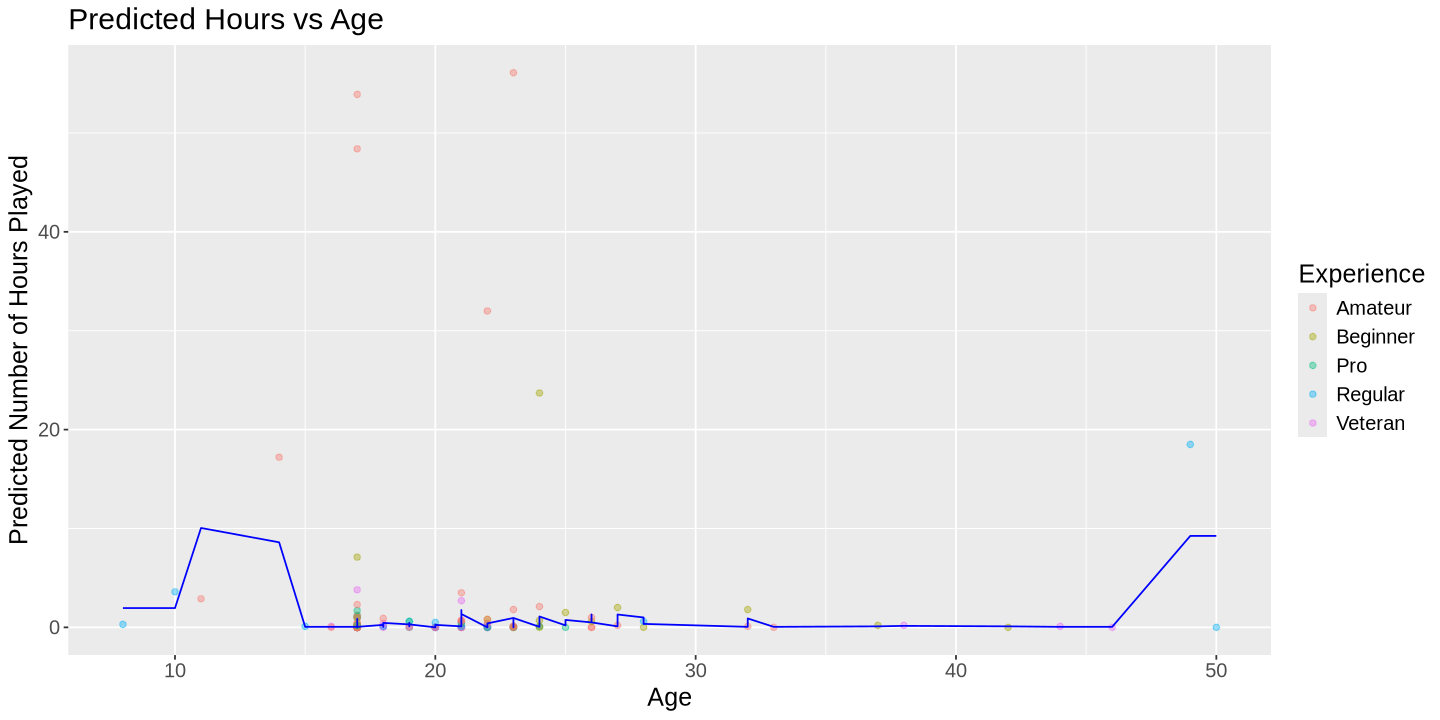

In [11]:
#Graph for visualizing predicted number of hours played shown by the line on the original scatter plot with the true values.

options(repr.plot.width = 12, repr.plot.height = 6)

player_preds <- player_best_fit |>
  predict(player_training) |>
  bind_cols(player_training)

player_plot <- player_preds |>
ggplot(aes(x = age , y = played_hours, colour = experience)) + 
geom_point(alpha = 0.4) +
geom_line(data = player_preds,
          mapping = aes(x = age, y = .pred), 
          color = "blue",) +
labs(x = "Age", 
     y = "Predicted Number of Hours Played",
     colour = "Experience") +
ggtitle("Predicted Hours vs Age ") +
theme(text = element_text(size = 15)) 

player_plot

#### Figure 3

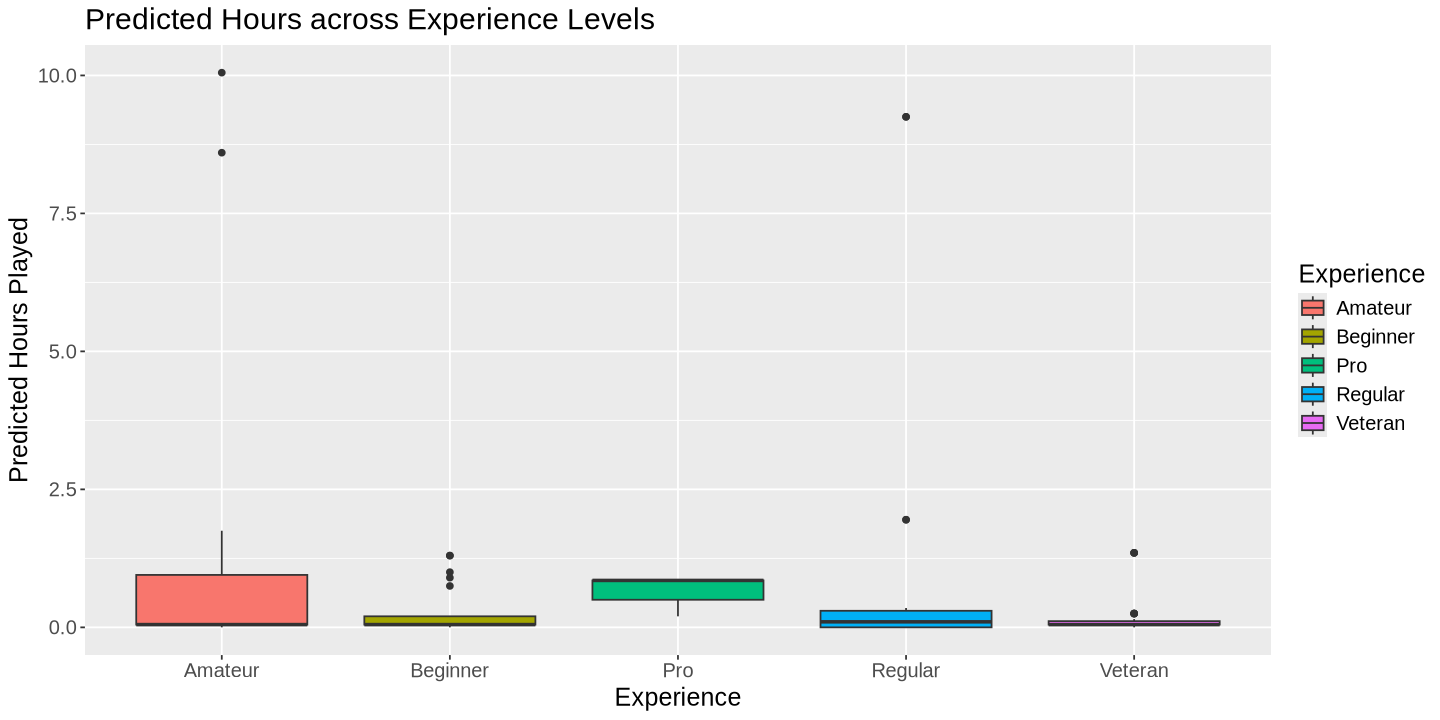

In [16]:
#Boxplot for visualizing the predicted hours played across the experience levels.

player_boxplot <- player_preds |>
ggplot(aes(x = experience , y = .pred, fill = experience)) + 
geom_boxplot() +
labs(x = "Experience", 
     y = "Predicted Hours Played",
     fill = "Experience") +
ggtitle("Predicted Hours across Experience Levels") +
theme(text = element_text(size = 15)) 
player_boxplot

#### Figure 4

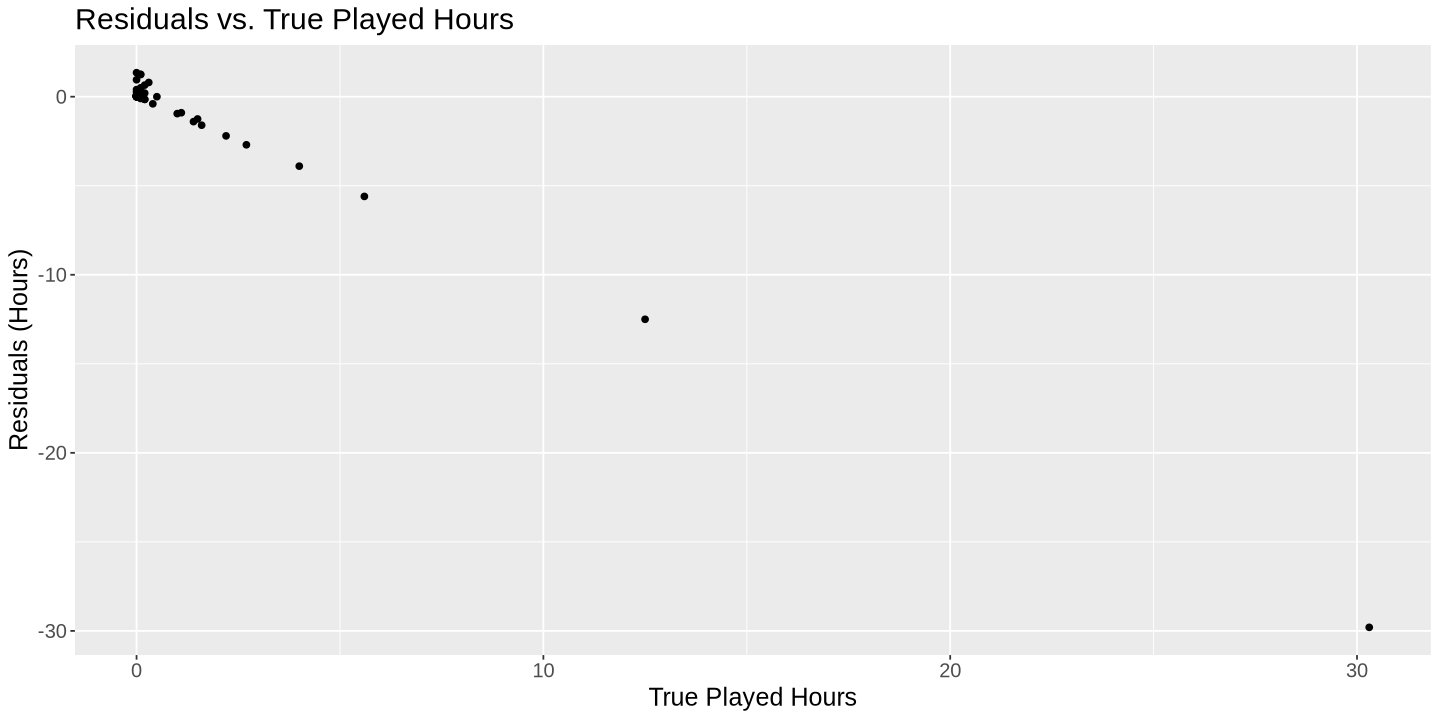

In [30]:
#Graph showing the error (residuals) between the true value and the predicted value.

player_Tpreds <- player_best_fit |>
    predict(player_testing) |>
    bind_cols(player_testing) |>
    mutate(residuals = .pred - played_hours)   

error_plot <- player_Tpreds |>
    ggplot(alpha = 0.4) +
    geom_point(aes(x = played_hours, y = residuals)) + 
    xlab("True Played Hours") + 
    ylab("Residuals (Hours)") +
    ggtitle("Residuals vs. True Played Hours") +
    theme(text = element_text(size = 15)) 
error_plot

## Discussion

#### Summary

Once again, the objective of this project is to know what types of players contribute most to the given dataset. This was done in exploring the modelled relationship in hours played, quantifying contribution, predicted by age and level of experience. In figure 2, the graph using k-nn regression represented by the blue line showed no clear relationship between hours played, age and player experience. In figure 3, a box plot was used with the categories being the players’ level of experience and the hours played for each level of experience, excluding age as a predictor. It was shown that players that self-identified as having ‘pro’ level experience were, on average, predicted to contribute more hours (around 0.8-1 hour) to the dataset compared to the rest of the levels of experiences, with ‘regular’ being the second highest. The majority of these boxplots didn’t have too much deviation, but amateur players showed a deviation skewed to having more hours played, despite having a lower mean hours played. The third figure highlights that as the predicted hours played increased (with values greater than 1 hour), the accuracy of the model appeared to decrease. 

#### Expectations

Before working on the dataset, the expectations were that players with a lower level of experience such as ‘beginner’  would spend more time playing the game in order to learn and understand it, and players with a significantly higher level of experience such as ‘pro’ and ‘veteran’ would also contribute more playing time to the dataset given that they are familiar with the game. The results of the project somewhat follow these expectations, given that the ‘pro’ level of experience contributed the most to the dataset on average, and the positively skewed distribution of the ‘amateur’ players aligning with these expectations. The ‘veteran’ and ‘beginner’ levels of experience, however, were among the least contributing types of players, with values that deviated much less from the mean compared to other categories. This result contradicts the expectation of higher playing time in these categories. 

#### Impact

Since self-classified amateur and pro players are seen to contribute somewhat more to the dataset than players with different experience, this can be applied to perhaps describe how a player progresses through a certain game, gaining more proficiency with more time spent. The more hours played in ‘amateu’r and ‘pro’ could possibly represent a plateau in skill level, where considerable time and effort is required to progress to the next step, or the competition is significantly more difficult. This information can be important to video game creators, in order to create a more immersive game that challenges a player, but isn’t too difficult to disengage them from the game, thus attracting more players to play the video game. 

#### Further Questions

This leads one to ask the question of what other variables in a video game that contribute to the immersion and perceived difficulty of the player, and how these variables can be refined to maximize player contribution in time spent participating. 